In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import combinations
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import het_arch

In [125]:
df_precios = pd.read_csv('Datos/Transformados/dow_jones_clean.csv')

In [126]:
df_precios['Unnamed: 0'] = pd.to_datetime(df_precios['Unnamed: 0'] )
df_precios.set_index('Unnamed: 0', inplace=True)


<Axes: xlabel='Unnamed: 0'>

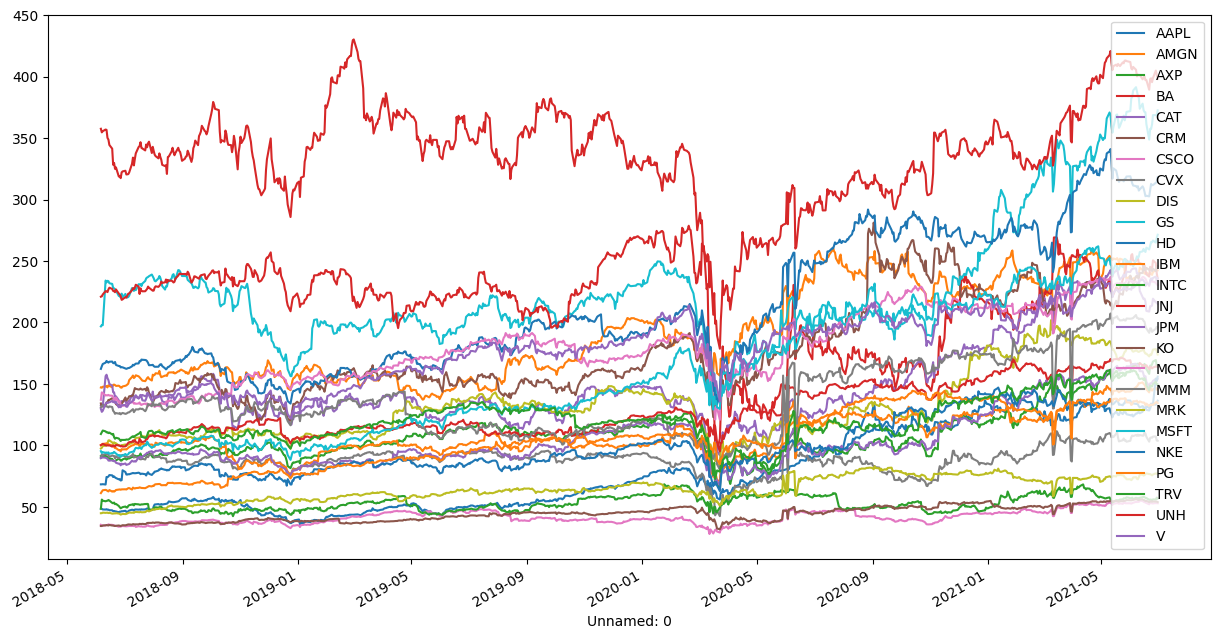

In [127]:
df_precios.plot(figsize=(15,8))

In [128]:
def calcular_metrics(df, freq_anual=252, rf=0.0):
    """
    Calcula rentabilidad, volatilidad, ratios de Sharpe, Sortino y drawdown máximo.
    
    Parámetros:
        df (DataFrame): precios ajustados, columnas=activos, index=fechas
        freq_anual (int): número de periodos al año para anualizar
        rf (float): rentabilidad libre de riesgo (diaria)
    
    Retorna:
        resumen (DataFrame): cada fila = un activo, columnas = métricas completas
    """
    resumen = pd.DataFrame(index=df.columns)
    
    # Rentabilidad diaria y log
    rent_simple = df.pct_change().dropna()
    rent_log = np.log(df / df.shift(1)).dropna()
    
    #Rentabilidad media diaria y anual
    resumen["Rentabilidad media diaria"] = rent_simple.mean()
    resumen["Rentabilidad media anual"] = rent_simple.mean() * freq_anual
    
    #Volatilidad diaria y anual
    resumen["Volatilidad diaria"] = rent_simple.std()
    resumen["Volatilidad anual"] = rent_simple.std() * np.sqrt(freq_anual)
    
    #Sharpe ratio anualizado (suponiendo rf diario = 0)
    resumen["Sharpe ratio"] = (resumen["Rentabilidad media anual"] - rf*freq_anual) / resumen["Volatilidad anual"]
    
    #Sortino ratio anualizado
    downside_std = rent_simple[rent_simple < 0].std()  # desviación solo de rendimientos negativos
    resumen["Sortino ratio"] = (resumen["Rentabilidad media anual"] - rf*freq_anual) / (downside_std * np.sqrt(freq_anual))
    
    #Drawdown máximo
    max_dd = {}
    for col in df.columns:
        precio_cum_max = df[col].cummax()
        dd = (df[col] / precio_cum_max) - 1
        max_dd[col] = dd.min()
    resumen["Drawdown máximo"] = pd.Series(max_dd)
    
    return resumen


In [129]:
df_metrics = calcular_metrics(df_precios)
df_metrics

,Rentabilidad media diaria,Rentabilidad media anual,Volatilidad diaria,Volatilidad anual,Sharpe ratio,Sortino ratio,Drawdown máximo
AAPL,0.001528,0.385123,0.021389,0.339543,1.134237,1.486121,-0.383931
AMGN,0.000883,0.222636,0.022750,0.361145,0.616473,0.826110,-0.245339
AXP,0.001064,0.268053,0.025743,0.408662,0.655927,0.873016,-0.496385
BA,0.000113,0.028505,0.035493,0.563433,0.050592,0.065410,-0.779201
CAT,0.000875,0.220579,0.023222,0.368640,0.598359,0.831417,-0.419463
CRM,0.001045,0.263249,0.023986,0.380764,0.691370,0.954544,-0.357158
CSCO,0.000787,0.198335,0.023855,0.378689,0.523741,0.659275,-0.419511
CVX,0.000666,0.167865,0.031451,0.499264,0.336225,0.425440,-0.557739
DIS,0.000946,0.238311,0.020984,0.333115,0.715400,0.984048,-0.431062
GS,0.001096,0.276163,0.024380,0.387016,0.713572,0.978248,-0.459535


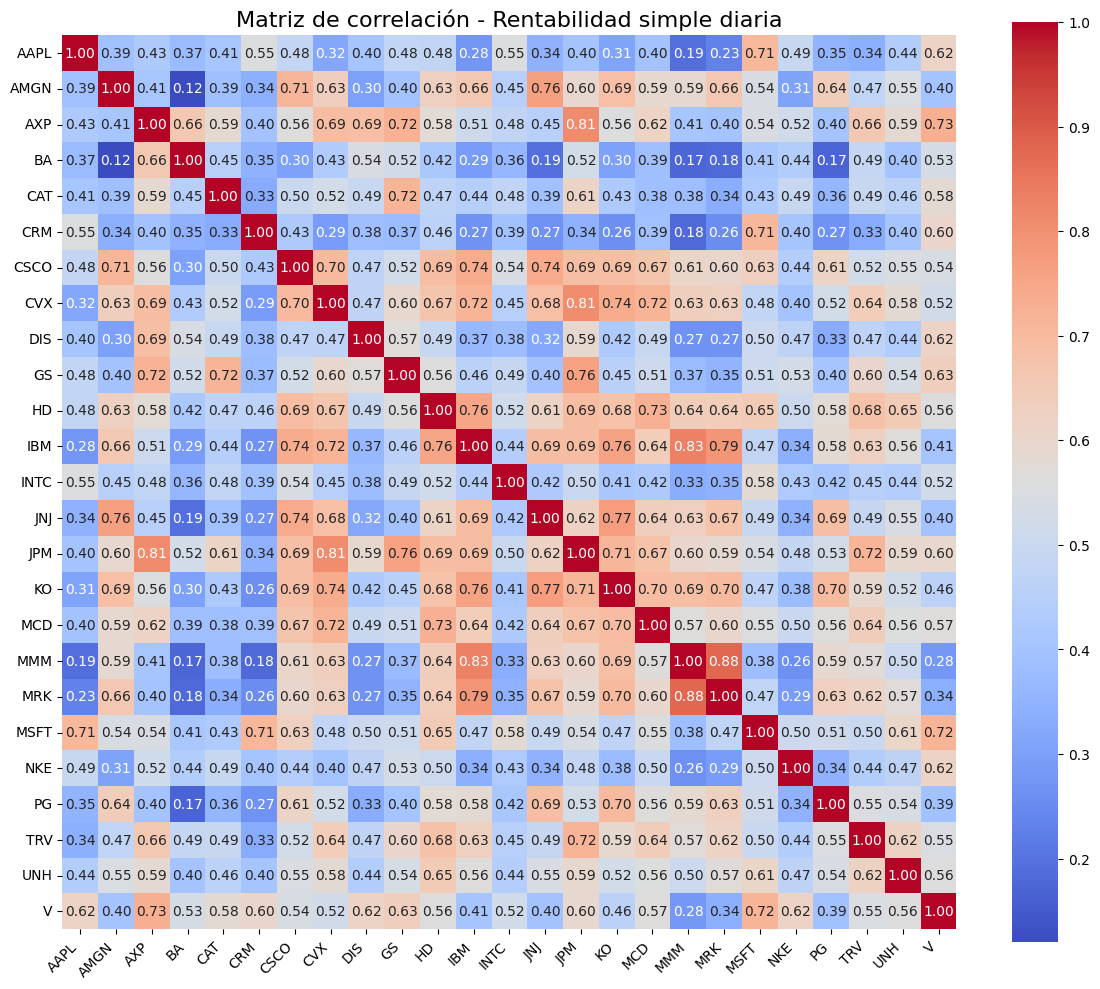

In [130]:
rent_simple = df_precios.pct_change()

# Matriz de correlación
corr_matrix = rent_simple.corr()

# Plot
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Matriz de correlación - Rentabilidad simple diaria", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [131]:

def seleccionar_y_graficar_cartera(df_precios, resumen_metrics, top_sharpe_percent=0.5, ventana_vol=21):
    """
    Selecciona 3 activos siguiendo la estrategia y genera gráficos:
    - Riesgo vs rentabilidad
    - Evolución del precio
    - Evolución de rentabilidad diaria
    - Evolución de volatilidad móvil
    
    Parámetros:
        df_precios (DataFrame): precios ajustados
        resumen_metrics (DataFrame): métricas de los activos
        top_sharpe_percent (float): porcentaje top de activos por Sharpe ratio
        ventana_vol (int): ventana en días para volatilidad móvil
        
    Retorna:
        activos_seleccionados, metrics_cartera
    """
    # ====== Selección de activos ======
    n_top = int(len(resumen_metrics) * top_sharpe_percent)
    top_activos = resumen_metrics.sort_values(by="Sharpe ratio", ascending=False).head(n_top).index.tolist()
    
    rent_simple = df_precios[top_activos].pct_change().dropna()
    corr_matrix = rent_simple.corr()
    
    mejores_combinaciones = []
    for trio in combinations(top_activos, 3):
        corr_12 = corr_matrix.loc[trio[0], trio[1]]
        corr_13 = (corr_matrix.loc[trio[0], trio[2]] + corr_matrix.loc[trio[1], trio[2]]) / 2
        mejores_combinaciones.append({
            "trio": trio,
            "corr_12": corr_12,
            "corr_13": corr_13,
            "score": -corr_12 + abs(0.5 - corr_13)
        })
    
    mejores_combinaciones = sorted(mejores_combinaciones, key=lambda x: x["score"], reverse=True)
    activos_seleccionados = mejores_combinaciones[0]["trio"]
    
    # ====== Métricas de la cartera ponderada igual ======
    pesos = np.array([1/3, 1/3, 1/3])
    rent_cartera = rent_simple[list(activos_seleccionados)].dot(pesos)
    rent_media_anual = rent_cartera.mean() * 252
    vol_anual = rent_cartera.std() * np.sqrt(252)
    sharpe_cartera = rent_media_anual / vol_anual
    metrics_cartera = pd.DataFrame({
        "Rentabilidad media anual": [rent_media_anual],
        "Volatilidad anual": [vol_anual],
        "Sharpe ratio": [sharpe_cartera]
    }, index=["Cartera"])
    
    # ====== Gráfico 1: Riesgo vs rentabilidad ======
    plt.figure(figsize=(12,8))
    plt.scatter(resumen_metrics["Volatilidad anual"], resumen_metrics["Rentabilidad media anual"], 
                c=resumen_metrics["Sharpe ratio"], cmap="viridis", s=100, alpha=0.7, label="Activos")
    
    for activo in activos_seleccionados:
        plt.scatter(resumen_metrics.loc[activo, "Volatilidad anual"], 
                    resumen_metrics.loc[activo, "Rentabilidad media anual"], 
                    color="red", s=150, edgecolors="black", label=f"Seleccionado: {activo}")
    
    plt.scatter(metrics_cartera["Volatilidad anual"], metrics_cartera["Rentabilidad media anual"], 
                color="black", s=200, marker="*", label="Cartera (ponderada)")
    plt.xlabel("Volatilidad anual")
    plt.ylabel("Rentabilidad anual")
    plt.title("Riesgo vs Rentabilidad - Activos y Cartera", fontsize=16)
    plt.colorbar(label="Sharpe ratio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # ====== Gráfico 2: Evolución del precio ======
    df_precios[list(activos_seleccionados)].plot(figsize=(12,6), title="Evolución del precio de los activos seleccionados")
    plt.xlabel("Fecha")
    plt.ylabel("Precio ajustado")
    plt.grid(True)
    plt.show()
    
    # ====== Gráfico 3: Evolución de la rentabilidad diaria ======
    rent_diaria = df_precios[list(activos_seleccionados)].pct_change().dropna()
    rent_diaria.plot(figsize=(12,6), title="Rentabilidad diaria de los activos seleccionados")
    plt.xlabel("Fecha")
    plt.ylabel("Rentabilidad diaria")
    plt.grid(True)
    plt.show()
    
    # ====== Gráfico 4: Volatilidad móvil ======
    vol_movil = rent_diaria.rolling(ventana_vol).std()
    vol_movil.plot(figsize=(12,6), title=f"Volatilidad móvil ({ventana_vol} días) de los activos seleccionados")
    plt.xlabel("Fecha")
    plt.ylabel("Volatilidad")
    plt.grid(True)
    plt.show()
    
    return activos_seleccionados, metrics_cartera

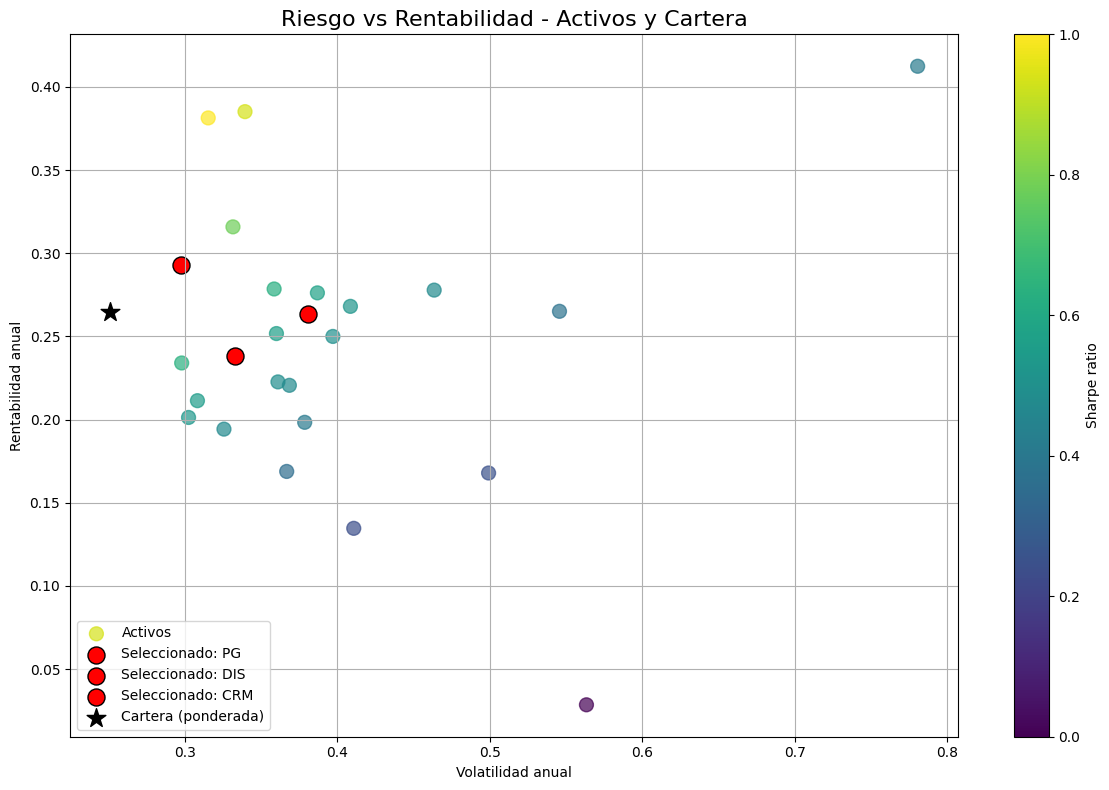

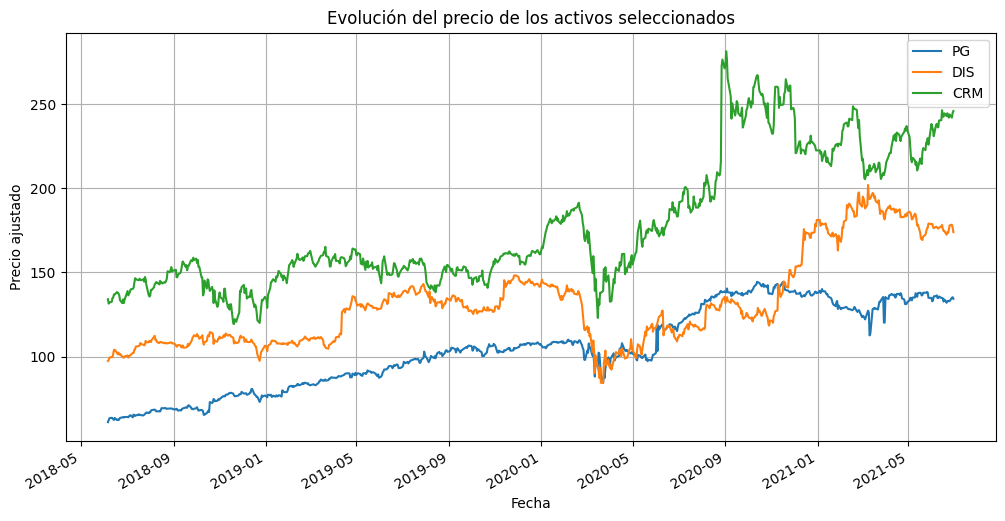

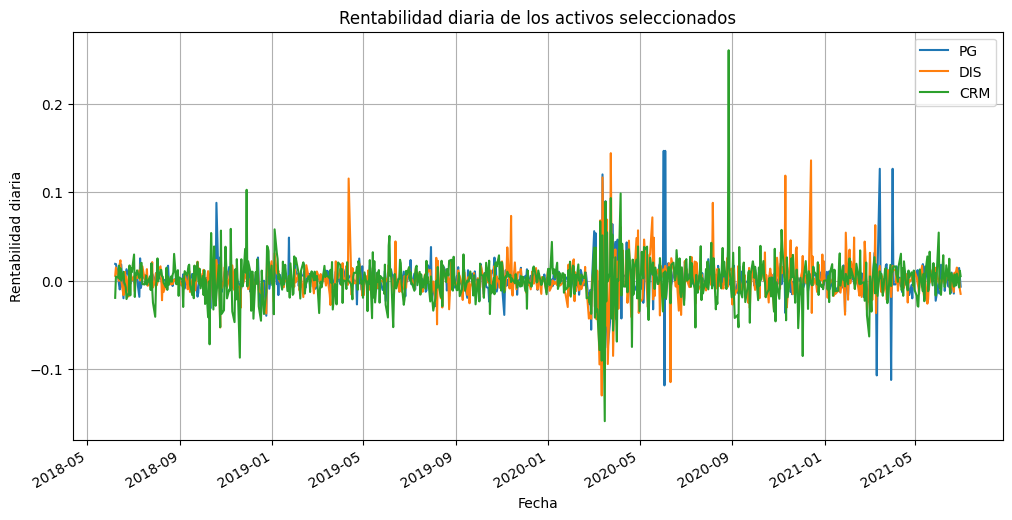

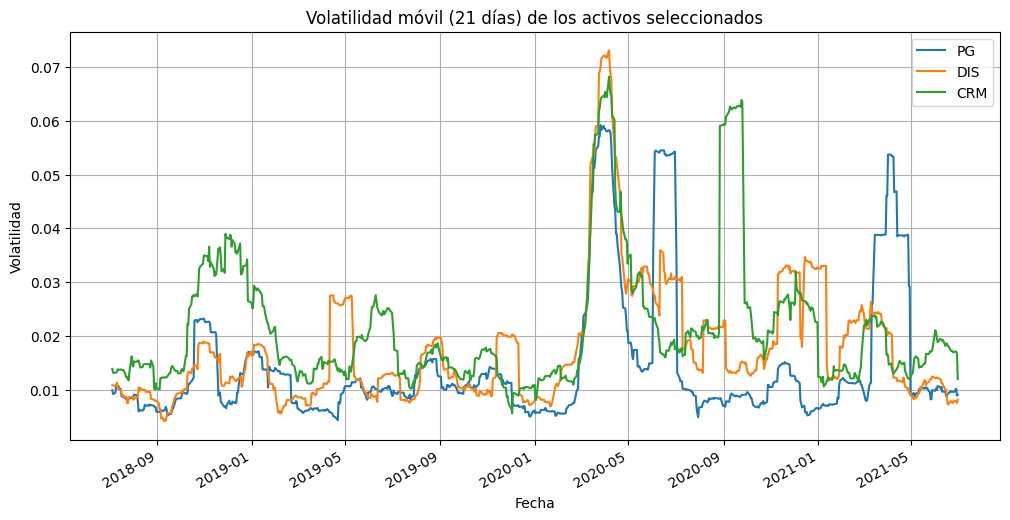

(('PG', 'DIS', 'CRM'),
          Rentabilidad media anual  Volatilidad anual  Sharpe ratio
 Cartera                  0.264857           0.251275      1.054053)

In [132]:
seleccionar_y_graficar_cartera(df_precios, df_metrics)

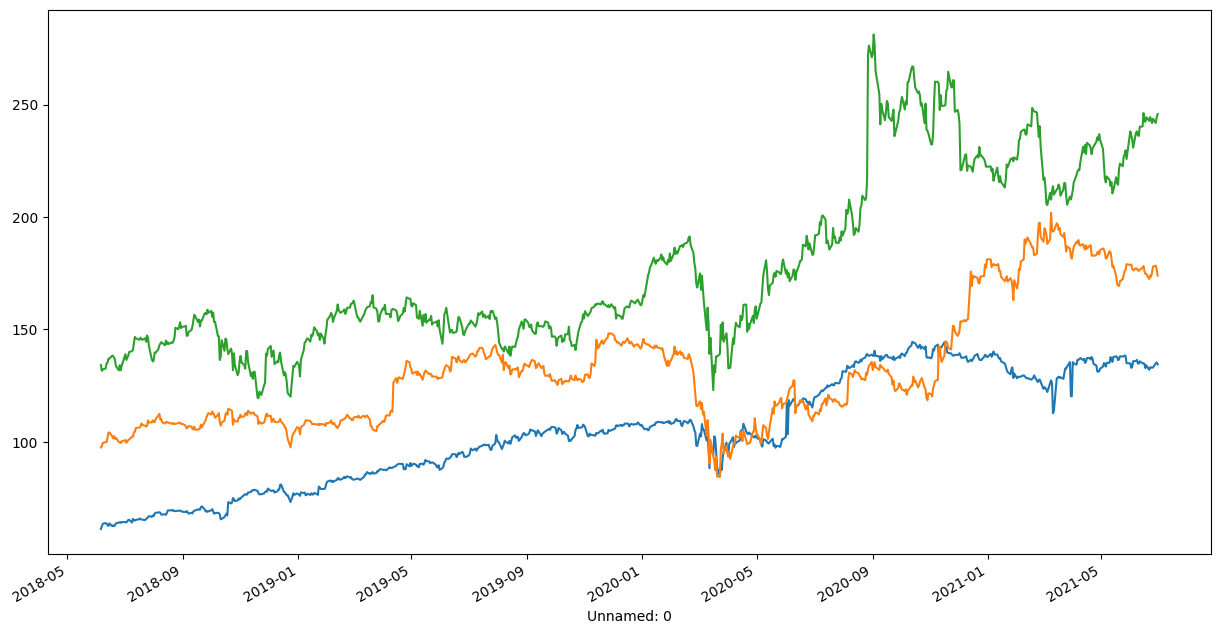

In [133]:
tickers = ['PG', 'DIS', 'CRM']
for ticker in tickers:
    serie = df_precios[ticker]
    serie.plot(figsize = (15,8))

In [134]:
df = df_precios[tickers]

In [135]:

df

,PG,DIS,CRM
Unnamed: 0,,,
2018-06-06,61.173698,97.482864,134.138977
2018-06-07,62.333824,98.018547,131.526459
2018-06-08,63.502174,99.462944,132.139999
2018-06-11,63.790142,99.816872,132.585327
2018-06-12,63.551537,99.797737,134.841599
...,...,...,...
2021-06-24,132.930000,175.330000,241.840000
2021-06-25,133.020000,177.930000,243.770000
2021-06-28,134.920000,178.350000,241.870000


C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\3385465812.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()
C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\3385465812.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


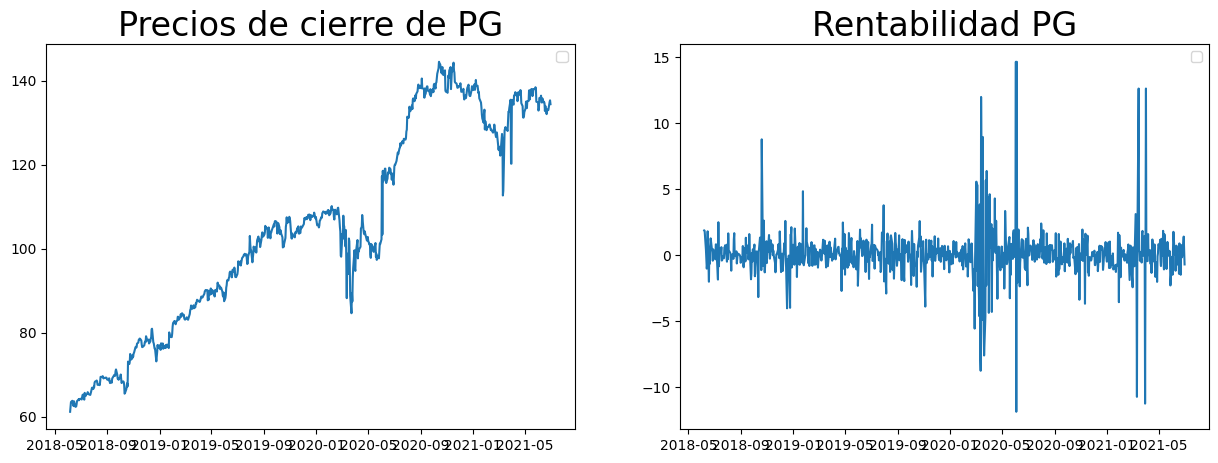

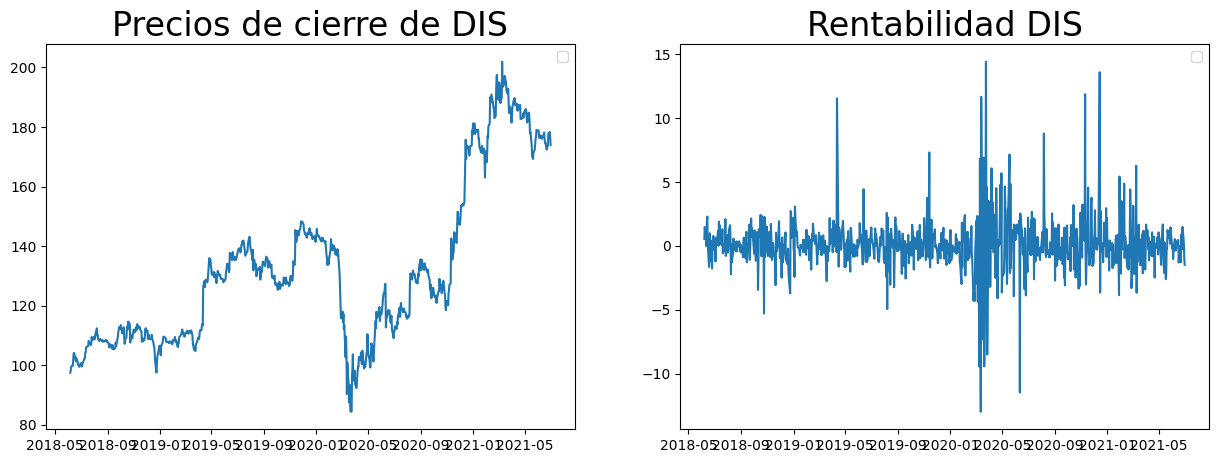

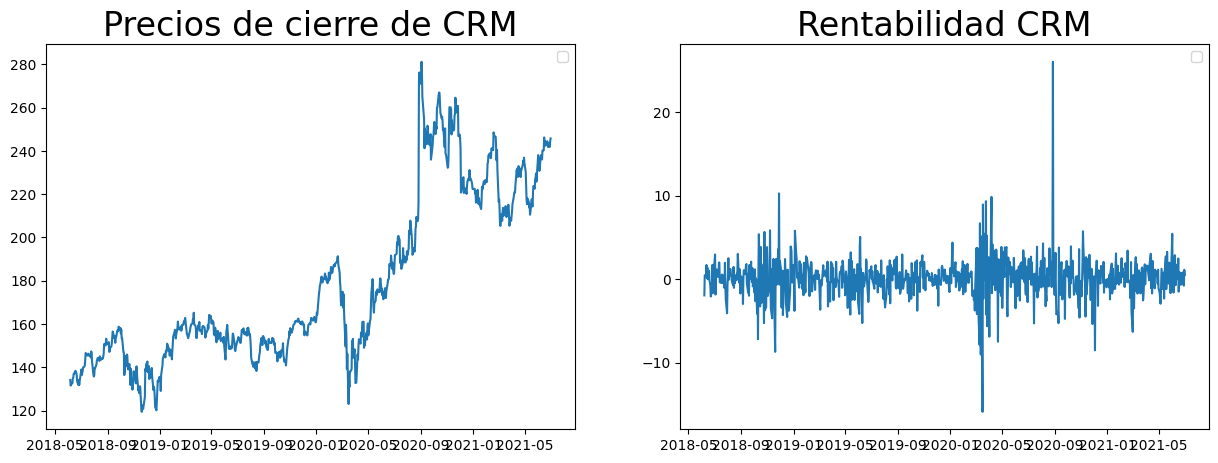

In [136]:
for i in tickers:
    rentabilidad = 100 * df[i].pct_change()
    rentabilidad.dropna(inplace=True)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].plot(df[i])
    ax[0].set_title('Precios de cierre de '+i, size = 24)
    ax[0].legend()

    ax[1].plot(rentabilidad)
    ax[1].set_title("Rentabilidad "+i, size = 24)
    ax[1].legend()

C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\2869852322.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()
C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\2869852322.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


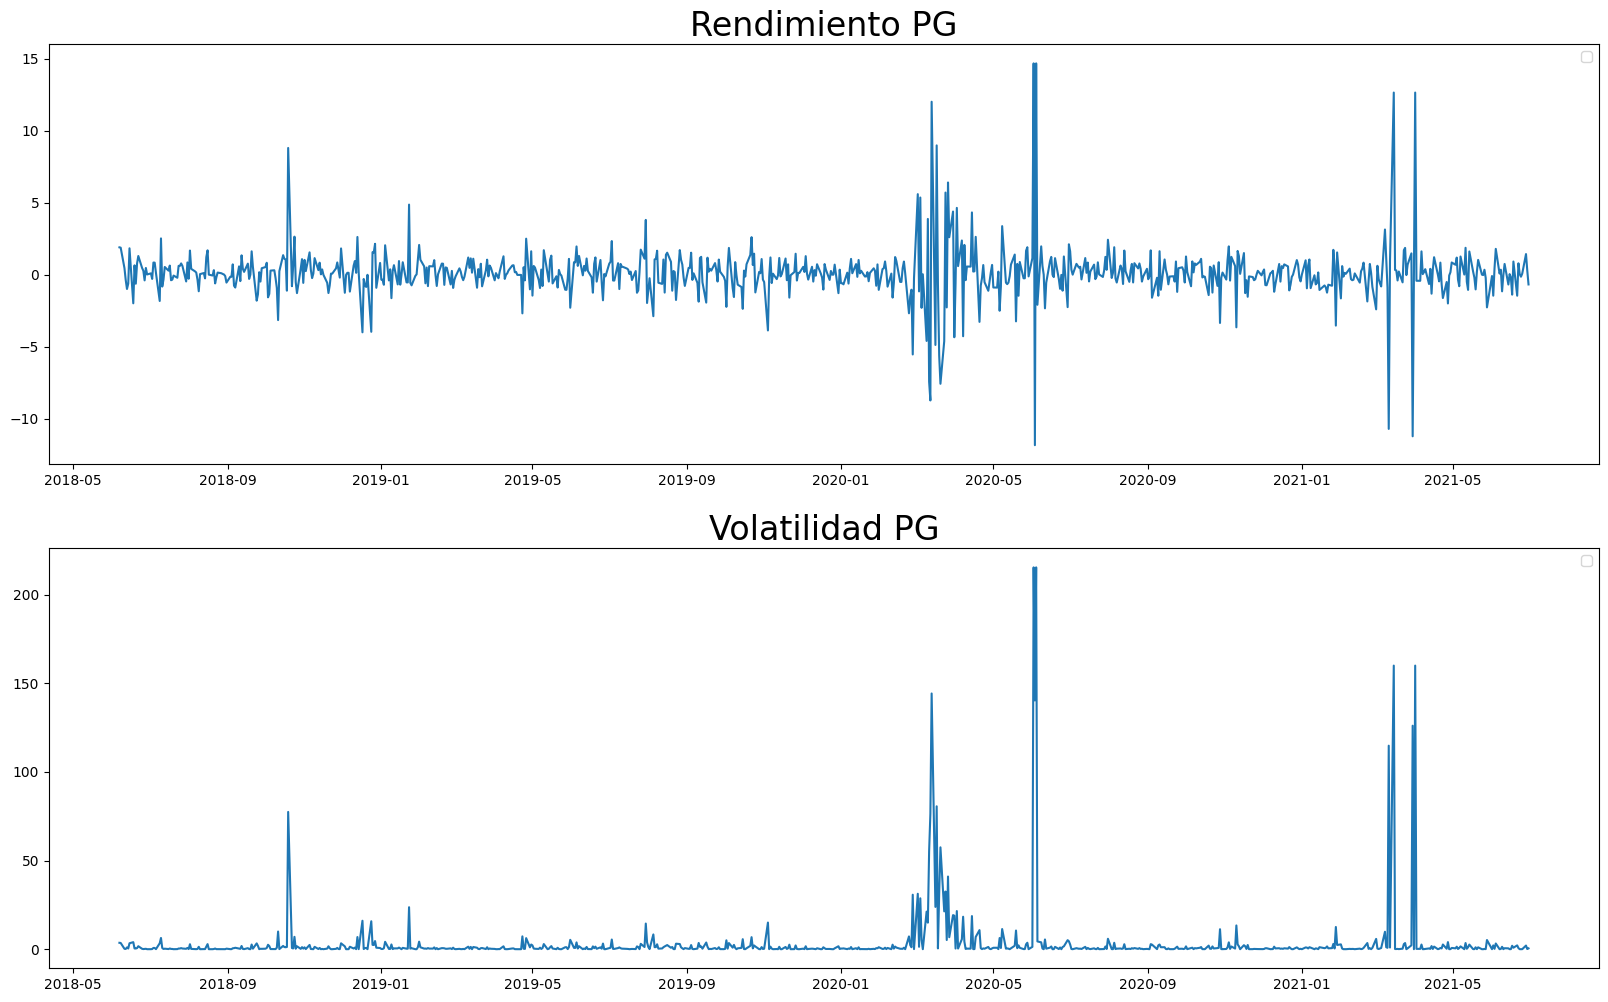

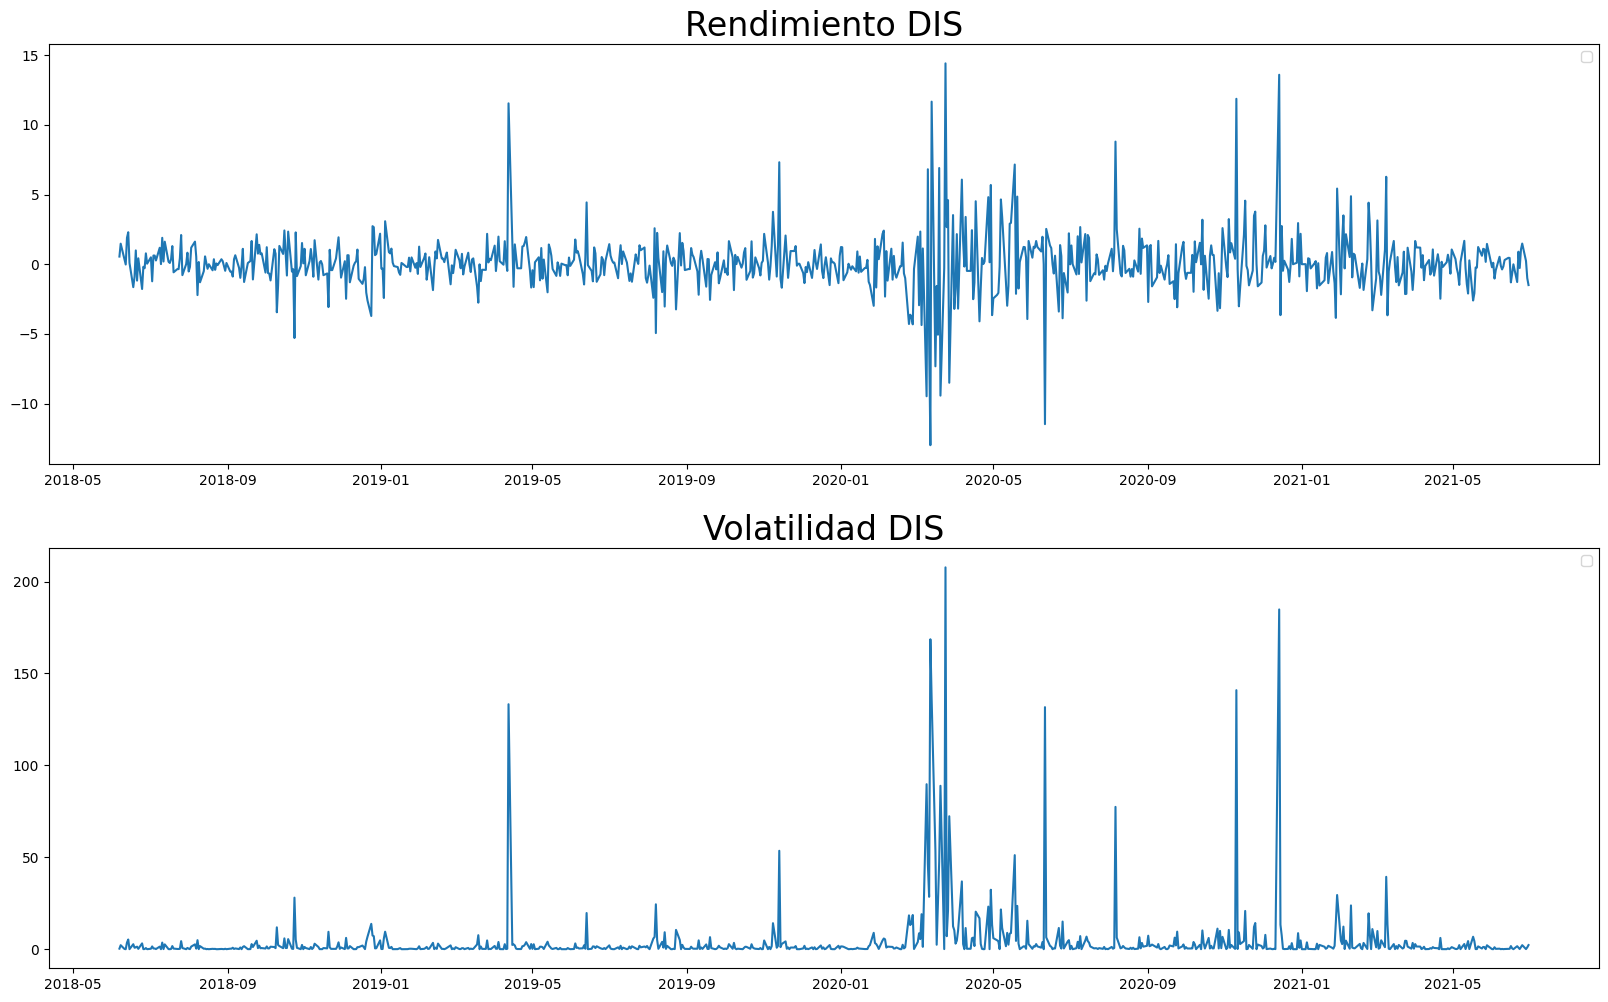

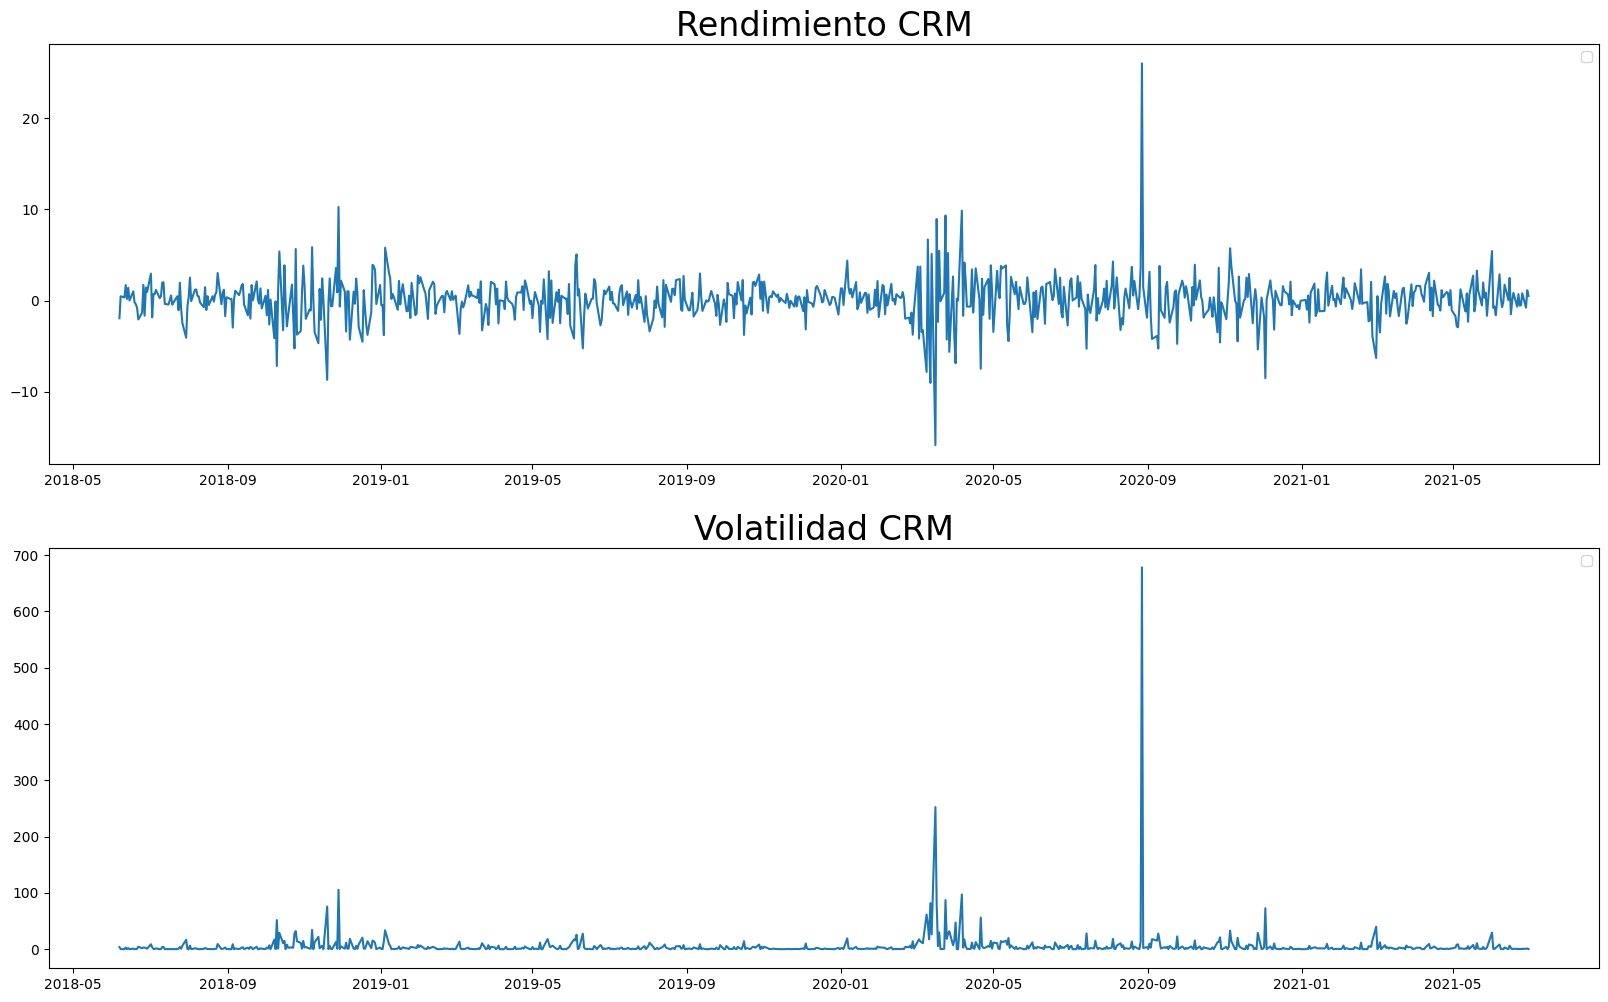

In [137]:
for i in tickers:
    rentabilidad = 100 * df[i].pct_change()
    rentabilidad.dropna(inplace=True)
    volatilidad = rentabilidad.mul(rentabilidad)
    plt.rcParams["figure.figsize"] = (20, 12)

    fig, ax = plt.subplots(2,1)

    ax[0].plot(rentabilidad)
    ax[0].set_title("Rendimiento "+i, size = 24)
    ax[0].legend()

    ax[1].plot(volatilidad)
    ax[1].set_title("Volatilidad "+i, size = 24)
    ax[1].legend()

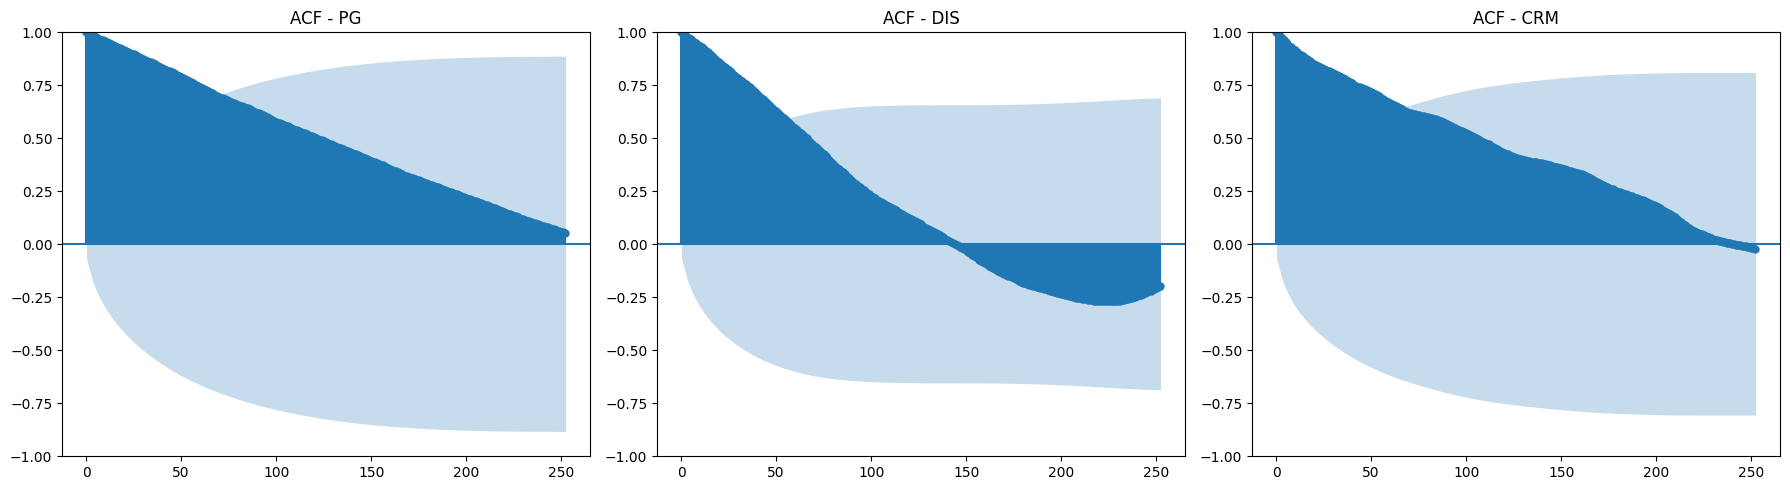

In [138]:
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 fila, 3 columnas

for i, ticker in enumerate(tickers):
    tsaplots.plot_acf(df_precios[ticker].dropna(), lags=252, ax=axes[i])
    axes[i].set_title(f"ACF - {ticker}")

plt.tight_layout()
plt.show()


In [139]:
# Descomposición para cada activo
for ticker in tickers:
    
    # Tomamos la serie temporal de precios ajustados
    serie = df_precios[ticker].dropna()
    
    # Descomposición clásica aditiva (suponiendo datos diarios, periodo=252 días ~ 1 año)
    decomposition = seasonal_decompose(serie, model='additive', period=252)
    
    # Componentes
    tendencia = decomposition.trend
    estacional = decomposition.seasonal
    residuo = decomposition.resid

    def adf_test(series):
        result = adfuller(series, autolag='AIC')
        print(f'p-value ADF: {result[1]}')

    def kpss_test(series, **kw):    
        statistic, p_value, n_lags, critical_values = kpss(series, **kw)
        print(f'p-value KPSS: {p_value}')
    
    lm_test = het_arch(residuo.dropna())
    adf_test(residuo.dropna())
    kpss_test(residuo.dropna())
    print(f"P-valor ARCH: {lm_test[3]:.4f}")

p-value ADF: 0.1645523687960087
p-value KPSS: 0.1
P-valor ARCH: 0.0000
p-value ADF: 0.04261583410183436
p-value KPSS: 0.027754964856838257
P-valor ARCH: 0.0000
p-value ADF: 0.09495426049288469
p-value KPSS: 0.09451834955895533
P-valor ARCH: 0.0000


C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\85487950.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


In [140]:
# Ninguna serie es estacionaria por lo que obtendremos el residuo restando los datos close - la tendencia o haciendo .diff

In [141]:
for i in tickers:
    # Tomamos la serie temporal de precios ajustados
    serie = df_precios[i].dropna()
    df['residuo_'+i] = serie.diff()
    df['renta_'+i] = 100*serie.pct_change()

df.head()

C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\2914889543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['residuo_'+i] = serie.diff()
C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\2914889543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['renta_'+i] = 100*serie.pct_change()
C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\2914889543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,PG,DIS,CRM,residuo_PG,renta_PG,residuo_DIS,renta_DIS,residuo_CRM,renta_CRM
Unnamed: 0,,,,,,,,,
2018-06-06,61.173698,97.482864,134.138977,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-07,62.333824,98.018547,131.526459,1.160126,1.896445,0.535683,0.549515,-2.612518,-1.947621
2018-06-08,63.502174,99.462944,132.139999,1.168350,1.874344,1.444397,1.473596,0.613541,0.466477
2018-06-11,63.790142,99.816872,132.585327,0.287968,0.453477,0.353928,0.355839,0.445328,0.337012
2018-06-12,63.551537,99.797737,134.841599,-0.238605,-0.374048,-0.019135,-0.019170,2.256271,1.701750


In [142]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'p-value ADF: {result[1]}')

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'p-value KPSS: {p_value}')

for i in tickers:
    lm_test = het_arch(df['renta_'+i].dropna())
    adf_test(df['renta_'+i].dropna())
    kpss_test(df['renta_'+i].dropna())
    print(f"P-valor ARCH: {lm_test[3]:.4f}")

p-value ADF: 4.250872111352075e-12
p-value KPSS: 0.1
P-valor ARCH: 0.0000
p-value ADF: 1.1167200001539205e-14
p-value KPSS: 0.1
P-valor ARCH: 0.0000
p-value ADF: 7.50568052811626e-16
p-value KPSS: 0.1
P-valor ARCH: 0.0995


C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\1960883344.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)
C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\1960883344.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)
C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\1960883344.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


In [143]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'p-value ADF: {result[1]}')

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'p-value KPSS: {p_value}')

for i in tickers:
    lm_test = het_arch(df['residuo_'+i].dropna())
    adf_test(df['residuo_'+i].dropna())
    kpss_test(df['residuo_'+i].dropna())
    print(f"P-valor ARCH: {lm_test[3]:.4f}")

p-value ADF: 8.202239597035309e-12
p-value KPSS: 0.1
P-valor ARCH: 0.0000
p-value ADF: 1.8305024480609922e-12
p-value KPSS: 0.1
P-valor ARCH: 0.0002
p-value ADF: 4.925205236816701e-16
p-value KPSS: 0.1
P-valor ARCH: 0.6486


C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\2719295136.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)
C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\2719295136.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)
C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\2719295136.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


In [144]:
for i in tickers:
    df['vol'+i] = df["residuo_"+i].mul(df["residuo_"+i])
df.head()

C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\1391758575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vol'+i] = df["residuo_"+i].mul(df["residuo_"+i])
C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\1391758575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vol'+i] = df["residuo_"+i].mul(df["residuo_"+i])
C:\Users\gorja\AppData\Local\Temp\ipykernel_28416\1391758575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,PG,DIS,CRM,residuo_PG,renta_PG,residuo_DIS,renta_DIS,residuo_CRM,renta_CRM,volPG,volDIS,volCRM
Unnamed: 0,,,,,,,,,,,,
2018-06-06,61.173698,97.482864,134.138977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-07,62.333824,98.018547,131.526459,1.160126,1.896445,0.535683,0.549515,-2.612518,-1.947621,1.345892,0.286956,6.825252
2018-06-08,63.502174,99.462944,132.139999,1.168350,1.874344,1.444397,1.473596,0.613541,0.466477,1.365042,2.086283,0.376432
2018-06-11,63.790142,99.816872,132.585327,0.287968,0.453477,0.353928,0.355839,0.445328,0.337012,0.082925,0.125265,0.198317
2018-06-12,63.551537,99.797737,134.841599,-0.238605,-0.374048,-0.019135,-0.019170,2.256271,1.701750,0.056933,0.000366,5.090760


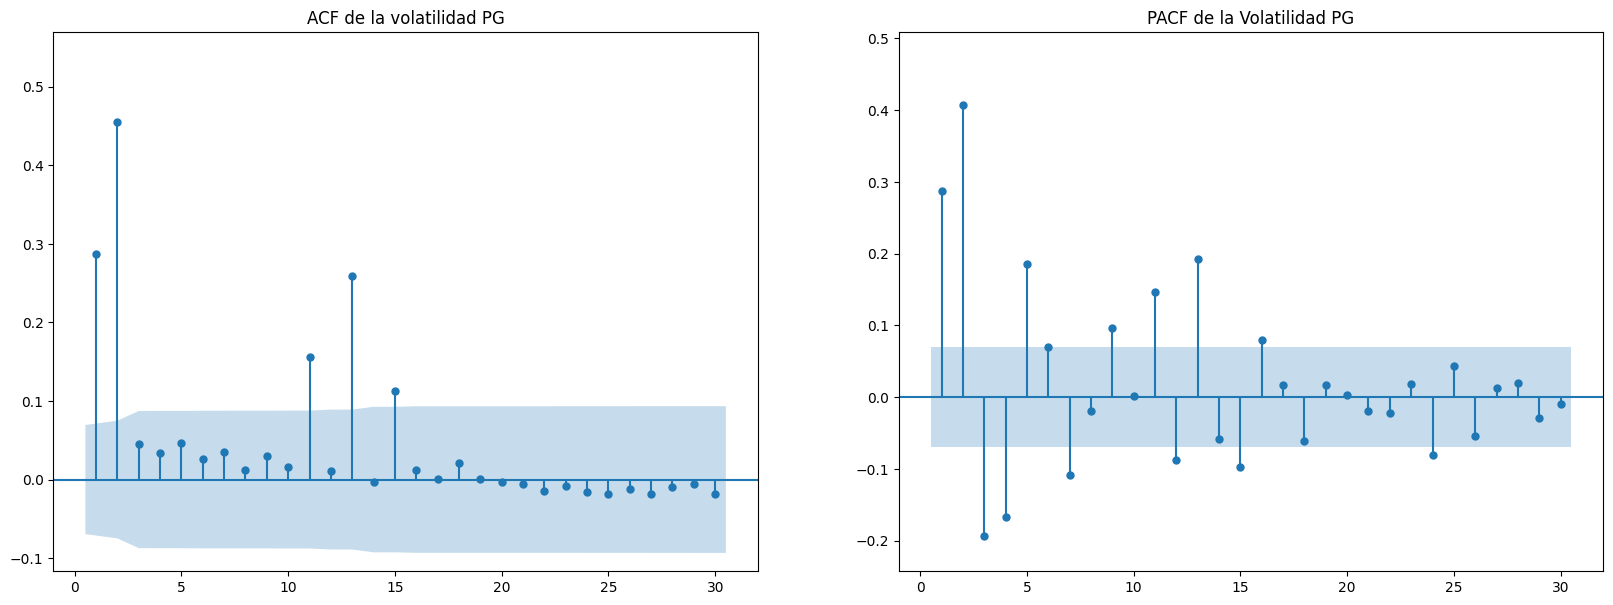

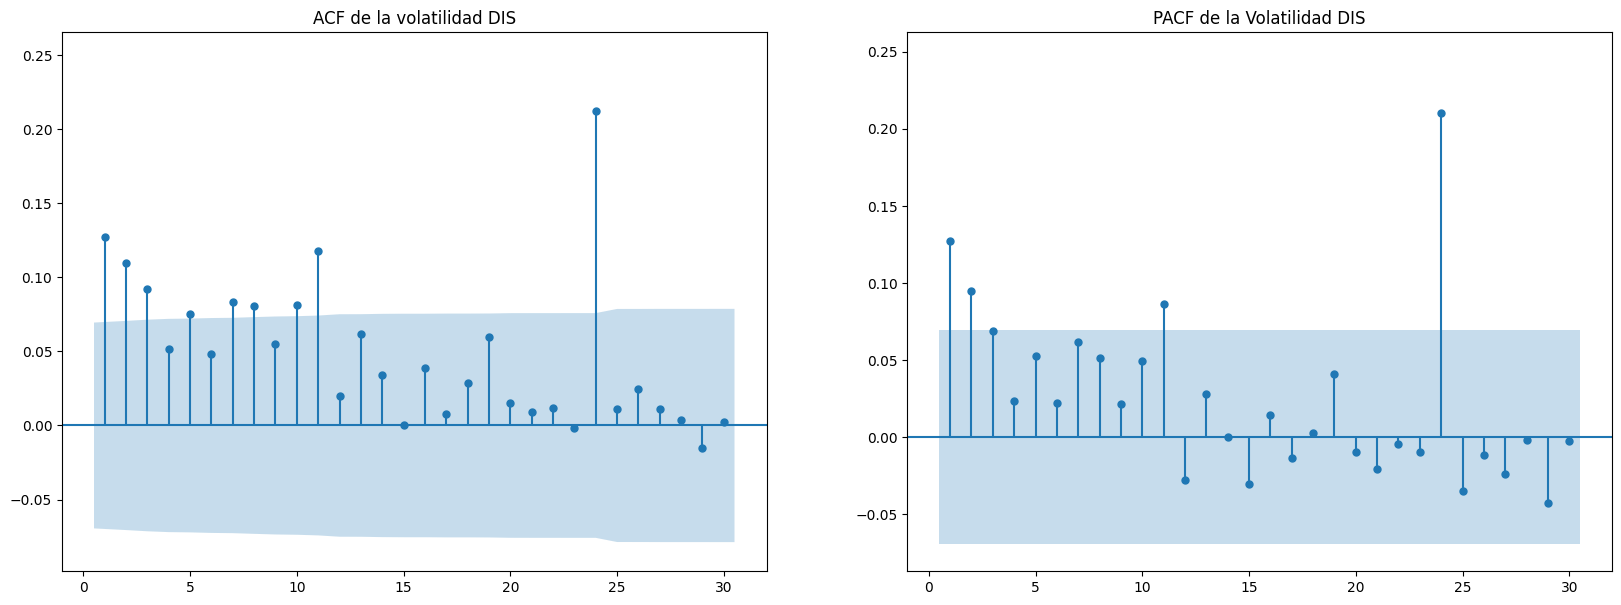

In [145]:
import statsmodels.graphics.tsaplots as sgt
for i in tickers[:2]:
    plt.rcParams["figure.figsize"] = (20, 7)

    fig, ax = plt.subplots(1,2)

    sgt.plot_acf(df['vol'+i].dropna(),ax=ax[0],zero = False, auto_ylims=True, title="ACF de la volatilidad "+i)
    sgt.plot_pacf(df['vol'+i].dropna(),ax=ax[1], zero = False,auto_ylims=True,title="PACF de la Volatilidad "+i);

In [146]:
# PG

In [147]:
from arch import arch_model
model1_GARCH52 = arch_model(df['residuo_PG'].dropna(), vol="GARCH", p=5, q=2, mean="AR")
results1_GARCH52 = model1_GARCH52.fit()
print(results1_GARCH52.summary())

Iteration:      1,   Func. Count:     11,   Neg. LLF: 2398.144201703277
Iteration:      2,   Func. Count:     26,   Neg. LLF: 2730.4080436629038
Iteration:      3,   Func. Count:     38,   Neg. LLF: 2559.3898727330843
Iteration:      4,   Func. Count:     50,   Neg. LLF: 2427.053042537883
Iteration:      5,   Func. Count:     61,   Neg. LLF: 2013.0463854258223
Iteration:      6,   Func. Count:     72,   Neg. LLF: 1424.8710273515028
Iteration:      7,   Func. Count:     83,   Neg. LLF: 1427.014507309625
Iteration:      8,   Func. Count:     94,   Neg. LLF: 1378.2547689174753
Iteration:      9,   Func. Count:    104,   Neg. LLF: 1377.2384716040383
Iteration:     10,   Func. Count:    114,   Neg. LLF: 1376.5186584646738
Iteration:     11,   Func. Count:    124,   Neg. LLF: 1376.1592982061277
Iteration:     12,   Func. Count:    134,   Neg. LLF: 1376.1230592764014
Iteration:     13,   Func. Count:    144,   Neg. LLF: 1376.1202060986661
Iteration:     14,   Func. Count:    154,   Neg. LLF: 

In [148]:
from arch import arch_model
model1_GARCH11 = arch_model(df['residuo_PG'].dropna(), vol="GARCH", p=1, q=1, mean="AR")
results1_GARCH11 = model1_GARCH11.fit()
print(results1_GARCH11.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4590.326345290472
Iteration:      2,   Func. Count:     17,   Neg. LLF: 367619.1393020976
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1448.1850088258252
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1391.8510439524343
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1391.8426178539526
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1391.8434054422771
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1391.841806459582
Iteration:      8,   Func. Count:     52,   Neg. LLF: 1391.8418046188776
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1391.8418023139152
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1391.8418046188776
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9
                           AR - GARCH Model Results                           
Dep. Variable:             residuo_PG   R-squared:         

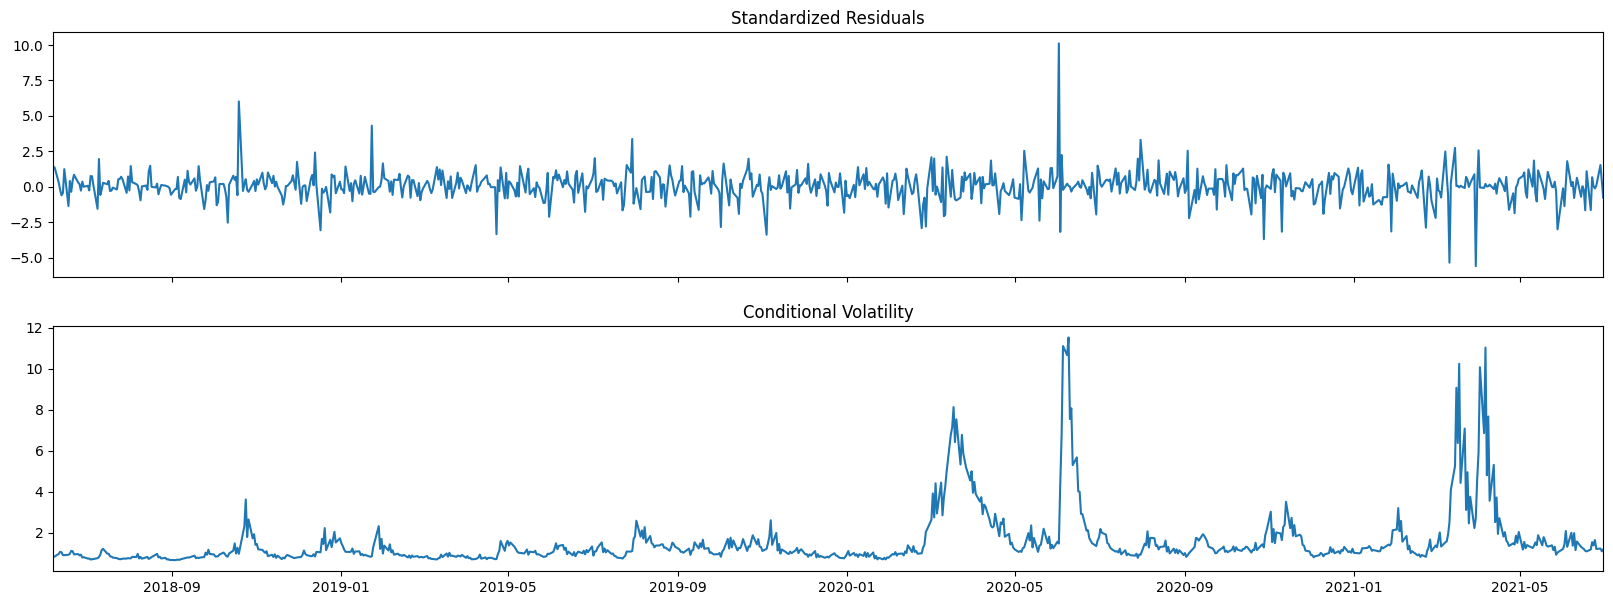

In [149]:
results1_GARCH52.plot()
plt.show()

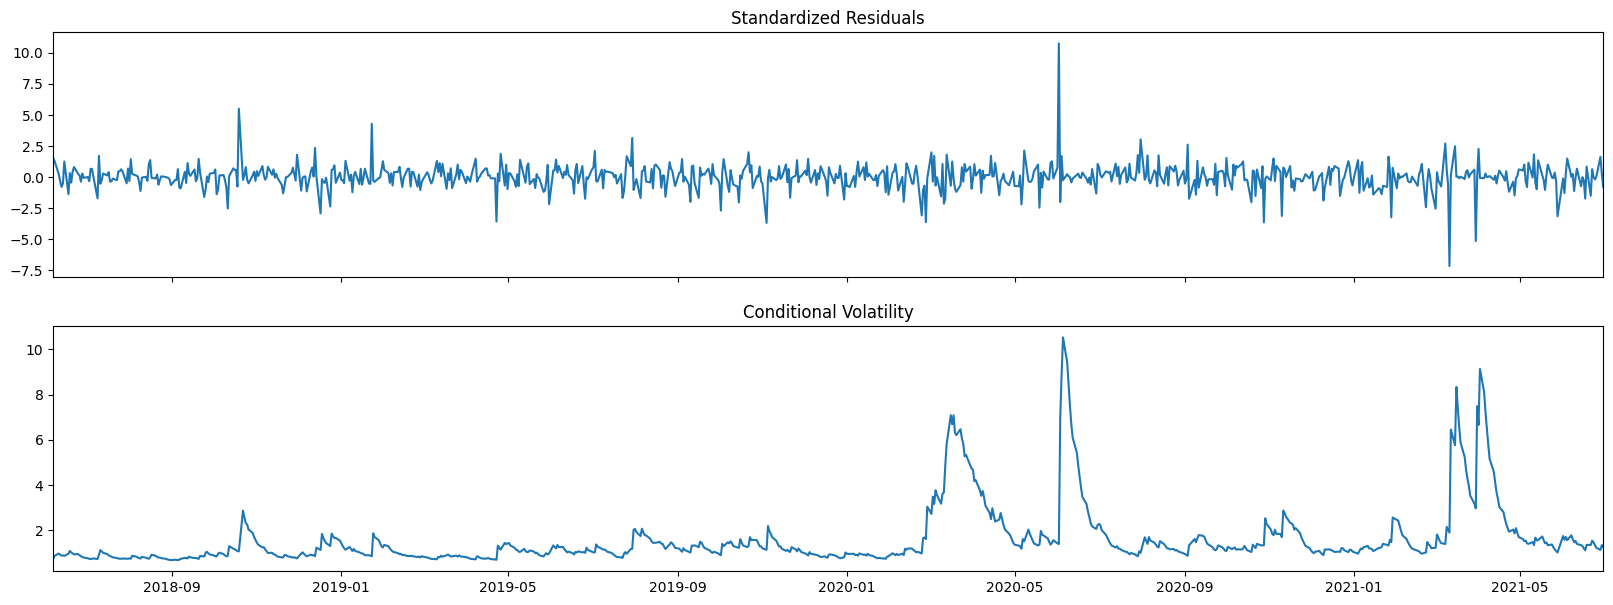

In [150]:
results1_GARCH11.plot()
plt.show()

In [151]:
GARCH52_resid = results1_GARCH52.std_resid
lm_test = het_arch(GARCH52_resid.dropna())
print(f"P-valor ARCH: {lm_test[3]:.4f}")

P-valor ARCH: 0.9317


In [152]:
GARCH11_resid = results1_GARCH11.std_resid
lm_test = het_arch(GARCH11_resid.dropna())
print(f"P-valor ARCH: {lm_test[3]:.4f}")

P-valor ARCH: 0.9993


In [153]:
index = df.index
index=index[len(index):None:-1] 
start_loc = 0
max_obs = len(model1_GARCH52.y) 
end_loc = max_obs - 20  

forecasts = {}
for i in range(20):
    last_obs_index = i + end_loc
    res = model1_GARCH52.fit(first_obs=start_loc, last_obs=last_obs_index, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_expand_GARCH52 = pd.DataFrame(forecasts).T
pred_variance_expand_GARCH52

,h.1
2021-06-02,4.435387
2021-06-03,1.726827
2021-06-04,4.024809
2021-06-07,1.916478
2021-06-08,3.947659
2021-06-09,1.353683
2021-06-10,2.495713
2021-06-11,1.743316
2021-06-14,1.601470
2021-06-15,1.475093


In [154]:
forecasts = {}
for i in range(20):
    res = model1_GARCH52.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
pred_variance_fixed_GARCH52 = pd.DataFrame(forecasts).T
pred_variance_fixed_GARCH52

 Done!


,h.1
2021-06-02,4.435387
2021-06-03,1.723770
2021-06-04,4.007303
2021-06-07,1.924388
2021-06-08,3.957539
2021-06-09,1.353625
2021-06-10,2.497133
2021-06-11,1.739962
2021-06-14,1.608172
2021-06-15,1.475946


In [155]:
index = df.index
index=index[len(index):None:-1] 
start_loc = 0
max_obs = len(model1_GARCH11.y) 
end_loc = max_obs - 20  

forecasts = {}
for i in range(20):
    last_obs_index = i + end_loc
    res = model1_GARCH11.fit(first_obs=start_loc, last_obs=last_obs_index, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_expand_GARCH11 = pd.DataFrame(forecasts).T
pred_variance_expand_GARCH11

,h.1
2021-06-02,2.924125
2021-06-03,2.447318
2021-06-04,3.176309
2021-06-07,2.587958
2021-06-08,2.162276
2021-06-09,2.353369
2021-06-10,1.942259
2021-06-11,1.806777
2021-06-14,1.712420
2021-06-15,1.433359


In [156]:
forecasts = {}
for i in range(20):
    res = model1_GARCH11.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
pred_variance_fixed_GARCH11 = pd.DataFrame(forecasts).T
pred_variance_fixed_GARCH11

 Done!


,h.1
2021-06-02,2.924125
2021-06-03,2.444932
2021-06-04,3.179605
2021-06-07,2.592199
2021-06-08,2.166528
2021-06-09,2.355614
2021-06-10,1.944146
2021-06-11,1.811112
2021-06-14,1.718312
2021-06-15,1.441546


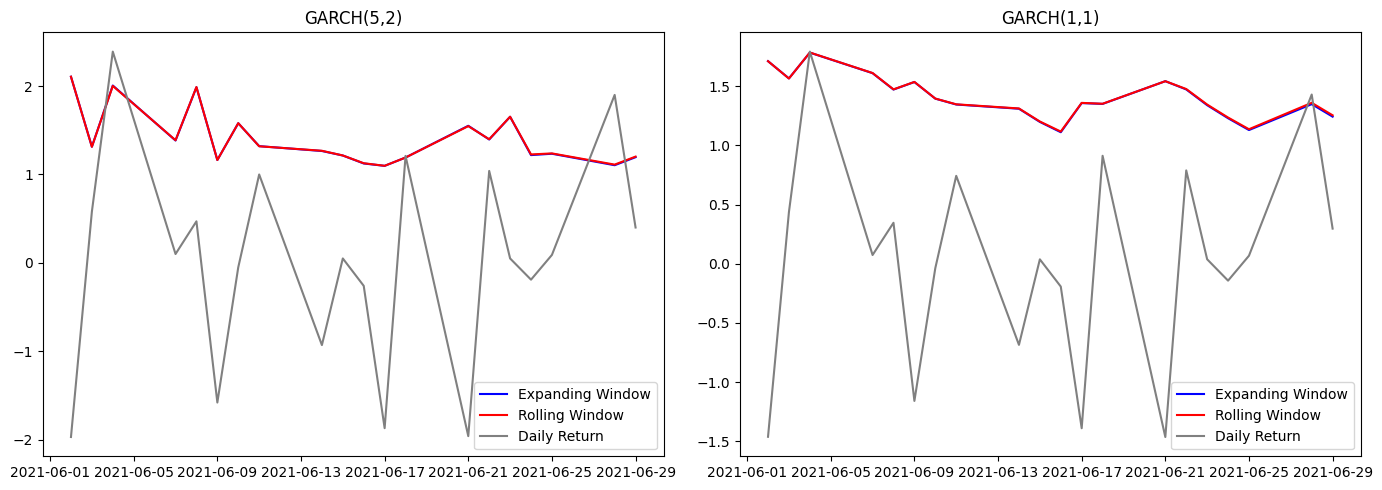

In [157]:
import matplotlib.pyplot as plt
import numpy as np

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- GARCH(5,2) ---
pred_vol_expand_GARCH52 = np.sqrt(pred_variance_expand_GARCH52)
pred_vol_fixedwin_GARCH52 = np.sqrt(pred_variance_fixed_GARCH52)

axes[0].plot(pred_vol_expand_GARCH52, color='blue', label='Expanding Window')
axes[0].plot(pred_vol_fixedwin_GARCH52, color='red', label='Rolling Window')
axes[0].plot(df['residuo_PG'].loc[pred_variance_expand_GARCH52.index],
             color='grey', label='Daily Return')
axes[0].set_title('GARCH(5,2)')
axes[0].legend()

# --- GARCH(1,1) ---
pred_vol_expand_GARCH11 = np.sqrt(pred_variance_expand_GARCH11)
pred_vol_fixedwin_GARCH11 = np.sqrt(pred_variance_fixed_GARCH11)

axes[1].plot(pred_vol_expand_GARCH11, color='blue', label='Expanding Window')
axes[1].plot(pred_vol_fixedwin_GARCH11, color='red', label='Rolling Window')
axes[1].plot(df['renta_PG'].loc[pred_variance_expand_GARCH11.index],
             color='grey', label='Daily Return')
axes[1].set_title('GARCH(1,1)')
axes[1].legend()

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [158]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast);
    print('Mean Absolute Error (MAE): {:.3g}'.format(mae))
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast);
    print('Mean Squared Error (MSE): {:.3g}'.format(mse))
    return mae, mse

In [159]:
vol = df['residuo_PG'].sub(df['residuo_PG'].mean()).pow(2)[pred_variance_expand_GARCH52.index]
var = df['residuo_PG'].sub(df['residuo_PG'].mean())[pred_variance_expand_GARCH52.index]

In [160]:
evaluate(vol, pred_vol_expand_GARCH52);
evaluate(vol, pred_vol_fixedwin_GARCH52);

Mean Absolute Error (MAE): 1.46
Mean Squared Error (MSE): 2.8
Mean Absolute Error (MAE): 1.46
Mean Squared Error (MSE): 2.8


In [161]:
vol = df['residuo_PG'].sub(df['residuo_PG'].mean()).pow(2)[pred_variance_expand_GARCH11.index]
var = df['residuo_PG'].sub(df['residuo_PG'].mean())[pred_variance_expand_GARCH11.index]

In [162]:
evaluate(vol, pred_vol_expand_GARCH11);
evaluate(vol, pred_vol_fixedwin_GARCH11);

Mean Absolute Error (MAE): 1.42
Mean Squared Error (MSE): 2.7
Mean Absolute Error (MAE): 1.42
Mean Squared Error (MSE): 2.71


In [163]:
# DIS

In [164]:
model2_GARCH23 = arch_model(df['residuo_DIS'].dropna(), vol="GARCH", p=2, q=3, mean="AR")
results2_GARCH23 = model2_GARCH23.fit()
print(results2_GARCH23.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4625.216815805391
Iteration:      2,   Func. Count:     23,   Neg. LLF: 2734.6528776664773
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1815.466237474477
Iteration:      4,   Func. Count:     43,   Neg. LLF: 1794.4186324491886
Iteration:      5,   Func. Count:     52,   Neg. LLF: 1810.9219015959184
Iteration:      6,   Func. Count:     61,   Neg. LLF: 1799.165967587046
Iteration:      7,   Func. Count:     70,   Neg. LLF: 1823.3626614859384
Iteration:      8,   Func. Count:     80,   Neg. LLF: 1793.1050288385404
Iteration:      9,   Func. Count:     89,   Neg. LLF: 1792.586302461962
Iteration:     10,   Func. Count:     97,   Neg. LLF: 6267.248282340684
Iteration:     11,   Func. Count:    107,   Neg. LLF: 1792.5119553470927
Iteration:     12,   Func. Count:    115,   Neg. LLF: 1792.5046014964323
Iteration:     13,   Func. Count:    123,   Neg. LLF: 1792.5030462205466
Iteration:     14,   Func. Count:    131,   Neg. LLF: 17

In [165]:
model2_GARCH11 = arch_model(df['residuo_DIS'].dropna(), vol="GARCH", p=1, q=1, mean="AR")
results2_GARCH11 = model2_GARCH11.fit()
print(results2_GARCH11.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3893.1770668334907
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3257.3731730962195
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1827.178014272718
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3067.7683938423916
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1793.6234312133083
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1905.2008564672542
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1796.3802860320316
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1792.6480124969703
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1792.6046370265337
Iteration:     10,   Func. Count:     63,   Neg. LLF: 1792.6044715164435
Iteration:     11,   Func. Count:     67,   Neg. LLF: 1792.604471515005
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1792.6044715164435
            Iterations: 11
            Function evaluations: 67
            Gradient evalu

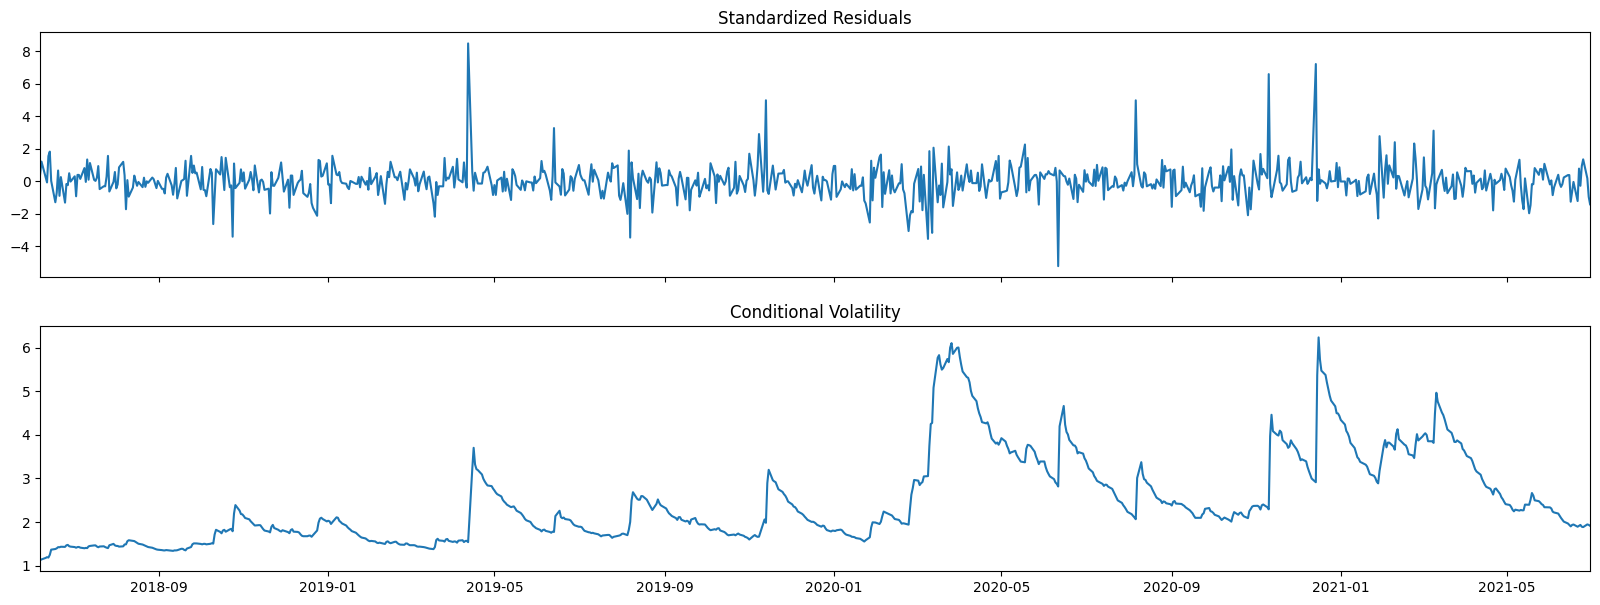

In [166]:
results2_GARCH23.plot()
plt.show()

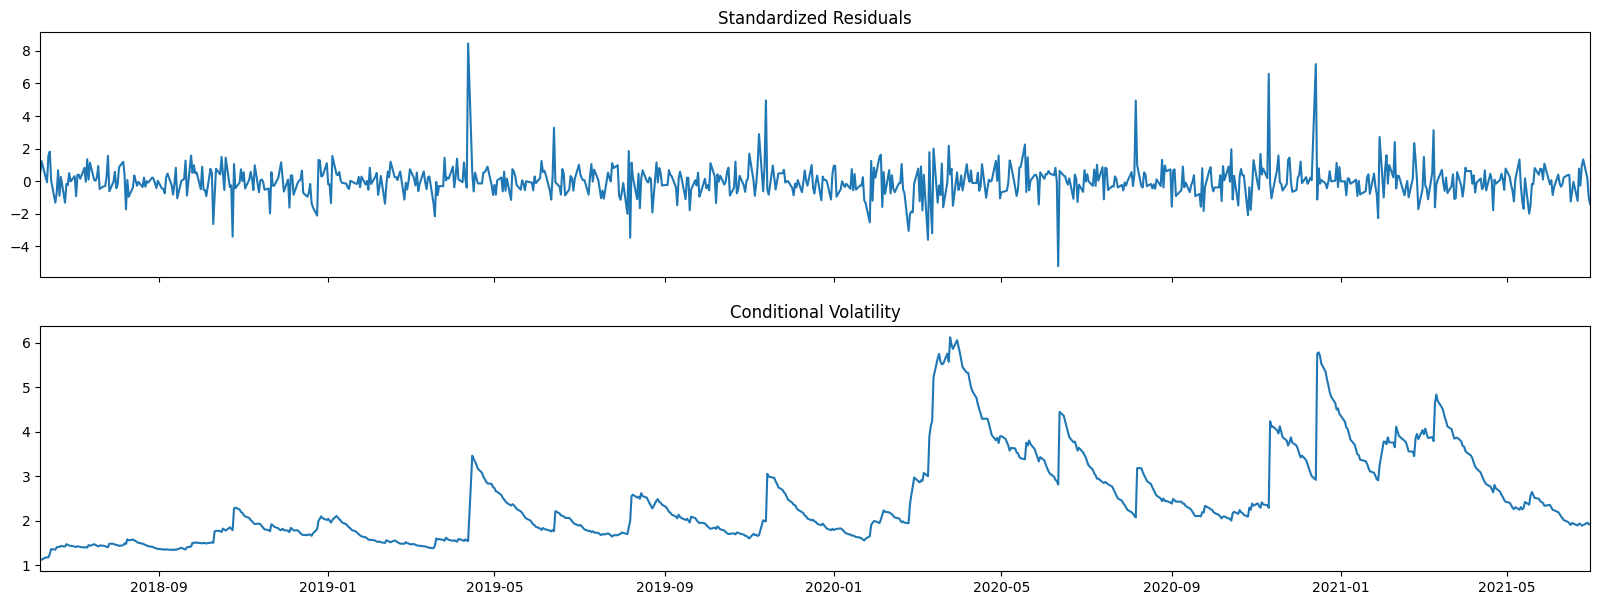

In [167]:
results2_GARCH11.plot()
plt.show()

In [168]:
GARCH23_resid = results2_GARCH23.std_resid
lm_test = het_arch(GARCH23_resid.dropna())
print(f"P-valor ARCH: {lm_test[3]:.4f}")

P-valor ARCH: 1.0000


In [169]:
GARCH11_resid = results2_GARCH11.std_resid
lm_test = het_arch(GARCH11_resid.dropna())
print(f"P-valor ARCH: {lm_test[3]:.4f}")

P-valor ARCH: 1.0000


In [170]:
index = df.index
index=index[len(index):None:-1] 
start_loc = 0
max_obs = len(model2_GARCH23.y) 
end_loc = max_obs - 20  

forecasts = {}
for i in range(20):
    last_obs_index = i + end_loc
    res = model2_GARCH23.fit(first_obs=start_loc, last_obs=last_obs_index, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_expand_GARCH23 = pd.DataFrame(forecasts).T
pred_variance_expand_GARCH23

,h.1
2021-06-02,5.187967
2021-06-03,5.176438
2021-06-04,4.961573
2021-06-07,4.760452
2021-06-08,4.539033
2021-06-09,4.359447
2021-06-10,4.161795
2021-06-11,3.934254
2021-06-14,3.832216
2021-06-15,3.637089


In [171]:
forecasts = {}
for i in range(20):
    res = model2_GARCH23.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_fixed_GARCH23 = pd.DataFrame(forecasts).T
pred_variance_fixed_GARCH23

,h.1
2021-06-02,5.187967
2021-06-03,5.164720
2021-06-04,4.952098
2021-06-07,4.740849
2021-06-08,4.508664
2021-06-09,4.290611
2021-06-10,4.135112
2021-06-11,3.994910
2021-06-14,3.896845
2021-06-15,3.771674


In [172]:
index = df.index
index=index[len(index):None:-1] 
start_loc = 0
max_obs = len(model2_GARCH11.y) 
end_loc = max_obs - 20  

forecasts = {}
for i in range(20):
    last_obs_index = i + end_loc
    res = model2_GARCH11.fit(first_obs=start_loc, last_obs=last_obs_index, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_expand_GARCH11 = pd.DataFrame(forecasts).T
pred_variance_expand_GARCH11

,h.1
2021-06-02,5.179195
2021-06-03,5.135704
2021-06-04,4.927748
2021-06-07,4.736346
2021-06-08,4.514047
2021-06-09,4.329349
2021-06-10,4.130467
2021-06-11,3.947896
2021-06-14,3.796377
2021-06-15,3.652298


In [173]:
forecasts = {}
for i in range(20):
    res = model2_GARCH11.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1, reindex=True).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

pred_variance_fixed_GARCH11 = pd.DataFrame(forecasts).T
pred_variance_fixed_GARCH11

,h.1
2021-06-02,5.179195
2021-06-03,5.125812
2021-06-04,4.919579
2021-06-07,4.718973
2021-06-08,4.486855
2021-06-09,4.322693
2021-06-10,4.148805
2021-06-11,3.961187
2021-06-14,3.856022
2021-06-15,3.728891


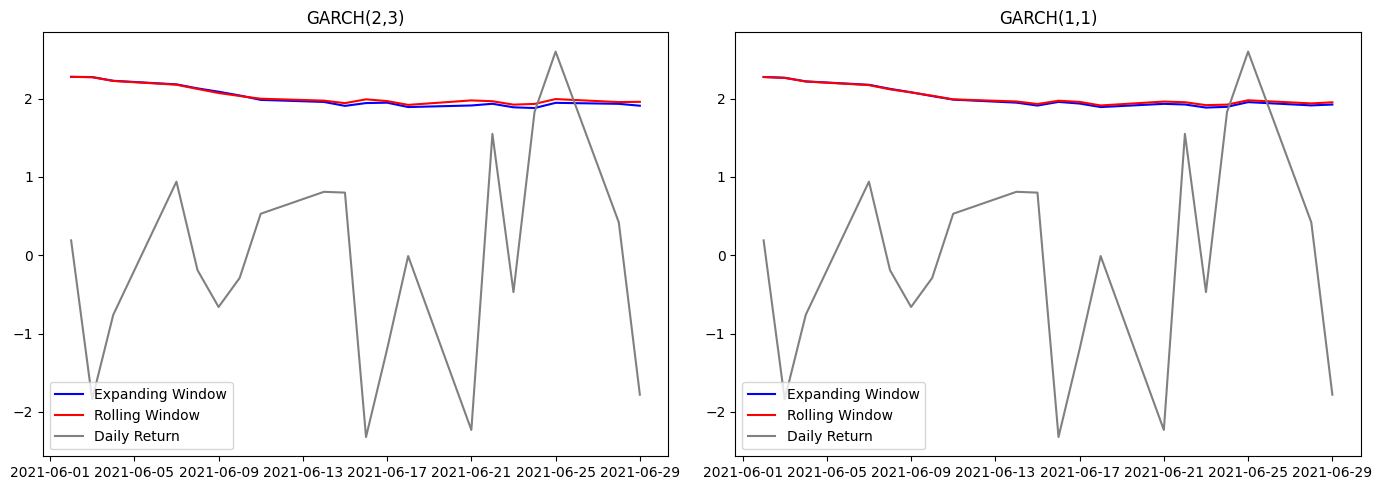

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# Crear figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- GARCH(2,3) ---
pred_vol_expand_GARCH23 = np.sqrt(pred_variance_expand_GARCH23)
pred_vol_fixedwin_GARCH23 = np.sqrt(pred_variance_fixed_GARCH23)

axes[0].plot(pred_vol_expand_GARCH23, color='blue', label='Expanding Window')
axes[0].plot(pred_vol_fixedwin_GARCH23, color='red', label='Rolling Window')
axes[0].plot(df['residuo_DIS'].loc[pred_variance_expand_GARCH23.index],
             color='grey', label='Daily Return')
axes[0].set_title('GARCH(2,3)')
axes[0].legend()

# --- GARCH(3,1,1) ---
pred_vol_expand_GARCH11 = np.sqrt(pred_variance_expand_GARCH11)
pred_vol_fixedwin_GARCH11 = np.sqrt(pred_variance_fixed_GARCH11)

axes[1].plot(pred_vol_expand_GARCH11, color='blue', label='Expanding Window')
axes[1].plot(pred_vol_fixedwin_GARCH11, color='red', label='Rolling Window')
axes[1].plot(df['residuo_DIS'].loc[pred_variance_expand_GARCH11.index],
             color='grey', label='Daily Return')
axes[1].set_title('GARCH(1,1)')
axes[1].legend()

# Ajustar diseño
plt.tight_layout()
plt.show()


In [175]:
vol = df['residuo_DIS'].sub(df['residuo_DIS'].mean()).pow(2)[pred_variance_expand_GARCH23.index]
var = df['residuo_DIS'].sub(df['residuo_DIS'].mean())[pred_variance_expand_GARCH23.index]

In [176]:
evaluate(vol, pred_vol_expand_GARCH23);
evaluate(vol, pred_vol_fixedwin_GARCH23);

Mean Absolute Error (MAE): 1.85
Mean Squared Error (MSE): 4.43
Mean Absolute Error (MAE): 1.84
Mean Squared Error (MSE): 4.37


In [177]:
vol = df['residuo_DIS'].sub(df['residuo_DIS'].mean()).pow(2)[pred_variance_expand_GARCH11.index]
var = df['residuo_DIS'].sub(df['residuo_DIS'].mean())[pred_variance_expand_GARCH11.index]

In [178]:
evaluate(vol, pred_vol_expand_GARCH11);
evaluate(vol, pred_vol_fixedwin_GARCH11);

Mean Absolute Error (MAE): 1.84
Mean Squared Error (MSE): 4.39
Mean Absolute Error (MAE): 1.84
Mean Squared Error (MSE): 4.38
